In [2]:
import os,sys,copy,subprocess,shutil,glob
import numpy as np
from astropy.io import fits as pf
from astropy.stats import sigma_clipped_stats, mad_std
from astropy.io import ascii
import astropy.units as u
from astropy.wcs import WCS
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.table import Table
from reproject import reproject_exact
import matplotlib.pyplot as plt
#import matplotlib
#%matplotlib inline
from matplotlib.colors import LogNorm
from ipywidgets import interact

# module to get PanSTARRS image
sys.path.append("/Users/sasada/python/")
import get_PanSTARRS

In [3]:
ps1_pixelscale = 0.25

# regions of parameter survey
### nsx = NSX = NSY
lnsx = [3,7,11,15]
### factors of the maximum value for iuk and tuk
luk = [1.,5., 10.,20.]

# paths of SExtractor and configuration files
SE = "/opt/local/bin/sex"
cps1 = "/Users/sasada/work/sextractor/ps1.sex"
cmit = "/Users/sasada/work/sextractor/mitsume.sex"

# path and initial parameters for HOTPANTS
HOTPANTS = "/Users/sasada/bin/hotpants"
iu   = 700.0 # upper limit
il   =  -500.0 # lower limit
# for PS1 tempate
tgain = 1.2
trnoi = 5.2
tu   =  45000.0
tl   = -700.0
nsx = 5


In [12]:
def get_ps1(w,SIZE,filters,overwrite=False):
  ### w : astropy.wcs.WCS
  ### SIZE : size of fov in arcmin (float)
  ### filters : filter name (str)
  ### return : saved filename

  ### calculate center pixel values
  cen_x, cen_y = w.pixel_shape[0] / 2,  w.pixel_shape[1] / 2
  ### calculate center coordinate
  RA, Dec = w.all_pix2world(cen_x,cen_y,1)
  RA, Dec = float(RA), float(Dec)
  pixelscale = np.sqrt(w.pixel_scale_matrix[0][0]**2+w.pixel_scale_matrix[0][1]**2) * 3600./2.
  X_max_minutes, Y_max_minutes = np.array(w.pixel_shape) * pixelscale / 60.
  SIZE = int(SIZE * 60 / ps1_pixelscale)
  url = get_PanSTARRS.geturl(ra=RA, dec=Dec, size=SIZE, filters=filters, format="fits", color=False)
  print(url)
  tag = '{:0>9.5f}{:0>+9.5f}_{:s}_{:d}'.format(RA, Dec, filters, SIZE).replace('.', '')
  fout = os.path.join(".", 'ps1_{:s}.fits'.format(tag))
  if overwrite == True or not os.path.exists(fout):
    fh = pf.open(url[0],cache=True)
    if os.path.exists(fout): os.remove(fout)
    fh.writeto(fout)
    print("  Save: {}".format(fout))
    fh.close()
  if os.path.exists(fout): 
    return fout
  else:
    print(" No File Saved")
    return None

def adjust_image(hdu1, hdu2, output="temp.fits", outref="temp2.fits", mask="mask.fits", mref="mref.fits"):
  # adjust input image and create mask images
  ### hdu1 : astropy.io.fits, open(file)[0] object for input image
  ### hdu2 : same object for reference image
  ### output : output image name for adjusted input image
  ### outref : same for PS1 image
  ### mask : mask image for adjusted input image
  ### mref : mask image for PS1 image
  ### return : image names which are created

  array, footprint = reproject_exact(hdu1, hdu2.header)
  marray = copy.deepcopy(array)
  marray[~np.isnan(marray)] = 0
  marray[np.isnan(marray)] = 1
  marr_ref = copy.deepcopy(hdu2.data)
  marr_ref[~np.isnan(marr_ref)] = 0
  marr_ref[np.isnan(marr_ref)] = 1
  pf.writeto(mask,marray,hdu2.header,overwrite=True)
  pf.writeto(mref,marr_ref,hdu2.header,overwrite=True)
  pf.writeto(output, array, hdu2.header, overwrite=True)
  pf.writeto(outref, hdu2.data, hdu2.header, overwrite=True)
  if os.path.exists(output) and os.path.exists(outref):
    return output, outref, mask, mref
  else:
    return None, None, None, None

def ng_est(fits, fref):
  # calculate ng parameter from point spread functions of input and reference images
  ### fits, fref : input and reference images
  ### return : strings of ng parameters for HOTPANTS

  # Do SExtractor. You need the FWHM_IMAGE column in the output catalog
  cmd = "{} -c {} {}".format(SE,cps1,fref)
  proc = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, encoding="utf_8")
  tab_ps1 = ascii.read("test.cat")
  os.remove("test.cat")
  fwhm_ps1, _, _ = sigma_clipped_stats(tab_ps1[tab_ps1["FLAGS"] == 0]["FWHM_IMAGE"])
  cmd = "{} -c {} {}".format(SE,cmit,fits)
  proc = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, encoding="utf_8")
  tab_in = ascii.read("test.cat")
  os.remove("test.cat")
  fwhm_in, _, _ = sigma_clipped_stats(tab_in[tab_in["FLAGS"] == 0]["FWHM_IMAGE"])
  # calculate pixel scale of input image
  w = WCS(pf.open(fits)[0])
  in_pixelscale = (w.wcs.cd[1,1]*u.deg).to("arcsec").to_value()
  fwhm_in = fwhm_in * in_pixelscale / ps1_pixelscale
  # calculate sigma_match
  sigma_match = np.sqrt((np.power(fwhm_in,2.0) - np.power(fwhm_ps1,2.0)) / (4*2*np.log(2)))
  ng = " -ng 3 6 {} 4 {} 2 {}".format(0.5*sigma_match,sigma_match,2.0*sigma_match)
  print("-ng: {}".format(ng))
  return ng

def extract_para(fin = "temp.fits", fref = "temp2.fits"):
  # extract upper and lower values around the center region of input and reference images
  ### fin : input image
  ### fref : reference image
  ### return : upper and lower values of input and reference images
  array = pf.getdata(fin)
  nx, ny = array.shape
  # cutout 1/3 to 2/3 of entire region
  st, en = int(nx / 3.), int(nx * 2. / 3.)
  omax, omin = np.max(array[st:en, st:en]), np.min(array[st:en, st:en])
  ps1_array = pf.getdata(fref)
  rmax, rmin = np.nanmax(ps1_array[st:en, st:en]), np.nanmin(ps1_array[st:en, st:en])
  IU, IL, TU, TL = omax + 1000, omin - 500, rmax + 1000, rmin - 500
  return IU, IL, TU, TL

def hotpants_sub(Input,Reference,output,gain,rnoi,mask="mask.fits",mref="mref.fits",iu=iu,il=il,iuk=None,tu=tu,tl=tl,tuk=None,nsx=nsx,STR=None):
  # run HOTPANTS
  ### Input, Reference, output : input, reference and output image names
  ### gain, rnoi : gain and readout noise values
  ### mask, mref : input and reference masks
  ### iu, il, iuk : upper and lower values, and upper value for making kernel of input image
  ### tu, tl, tuk : same of reference image
  ### nsx : nsx value
  ### STR : adding strings for executing HOTPANTS
  ### return : process result
  if iuk == None: iuk = iu
  if tuk == None: tuk = tu
  command, cmd = [], []
  cmd.append("{} ".format(HOTPANTS))
  cmd.append("-inim {0} -tmplim {1} -outim {2} ".format(Input,Reference,output))  
  if os.path.exists(mask): cmd.append("-imi {0} ".format(mask)) 
  if os.path.exists(mref): cmd.append("-tmi {0} ".format(mref)) 
  cmd.append("-iu {0} -il {1} -iuk {2} -ig {3} -ir {4} ".format(str(iu),str(il),str(iuk),str(gain),str(rnoi)))
  cmd.append("-tu {0} -tl {1} -tuk {2} -tg {3} -tr {4} ".format(str(tu),str(tl),str(tuk),str(tgain),str(trnoi)))
  cmd.append("-nsx {0} -nsy {0} -n i ".format(str(nsx)))
  if STR != None:
    cmd.append(STR)
  command.append("".join(cmd))
  #print(command[0])
  proc = subprocess.run(command[0], shell=True,stdout=subprocess.PIPE, stderr=subprocess.PIPE, encoding="utf_8")
  return proc.stderr.find("SUCCESS")
  #return True

def do_hotpants(Input,Reference,output,gain,rnoi,mask,mref,iu=iu,il=il,iuk=None,tu=tu,tl=tl,tuk=None,nsx=nsx,STR=None):
  # do HOTPANTS running function and calculate standard deviation of the subtraction image
  ### parameters are the same as hotpants_sub function
  ### return : values of median and standard deviation of the subtraction image
  if os.path.exists(output): os.remove(output)
  suc = False
  suc = hotpants_sub(Input,Reference,output,gain,rnoi,mask=mask,mref=mref,iu=iu,il=il,iuk=iuk,tu=tu,tl=tl,tuk=tuk,nsx=nsx,STR=STR)
  if not os.path.exists(output) or suc == False:
    print("No subtraction image is created.")
    return None, None
  hdul = pf.open(output)
  hdu_sub = hdul[0]
  arr = hdu_sub.data
  arr = arr[np.nonzero(arr)]
  _, Med, std = sigma_clipped_stats(arr[~np.isnan(arr)])
  hdu_sub.data = hdu_sub.data - Med
  hdul[0] = hdu_sub
  hdul.writeto(output,overwrite=True)
  return Med, std

def est_good_sub(FITS, REF, gain, rnoi):
  # survey of image subtraction to estimate good subtraction image
  ### FITS, REF : input and reference images
  ### gain, rnoi : gain and readout noise values
  ### return : input and subtraction images, and list of survey results including Filename, nsx, uk, normalized standard deviation, and standard deviation

  im_in = FITS.replace(".fits","_input.fits")
  im_out = FITS.replace(".fits","_output.fits")
  min_std = 1e30
  hdu1 = pf.open(FITS)[0]
  hdu2 = pf.open(REF)[0]
  w = WCS(hdu2.header)
  temp, temp2, mask, mref = adjust_image(hdu1, hdu2, output=im_in, outref="temp2.fits", mask="mask.fits", mref="mref.fits")
  ng = ng_est(FITS, temp2)
  IU, IL, TU, TL = extract_para(fin = temp, fref = temp2)
  _, _, std_in = sigma_clipped_stats(pf.getdata(temp))
  params = []
  for nsx in lnsx:
    for uk in luk:
      med, std = do_hotpants(temp,temp2,output="sub.fits",gain=gain,rnoi=rnoi,mask=mask,mref=mref,iu=IU,il=IL,iuk=IU/uk,tu=TU,tl=TL,tuk=TU/uk,nsx=nsx,STR=" -rss 30 -r 20 "+ng)
      if med == None:
        continue
      nstd = std/std_in
      print("nsx:{0}\t uk:{1}\t std/std_in:{2:.5f}".format(nsx, str(uk).zfill(4), nstd))
      FILENAME = "survey_nsx-{0}_uk-{1}.fits".format(nsx,str(uk).zfill(4))
      shutil.copy("sub.fits",FILENAME)
      params.append([FILENAME,nsx,uk,nstd,std])
      if (nstd < min_std) and (nstd != 0):
        min_std = nstd
        print("Mininum standard deviation. Updated.")
        shutil.copy("sub.fits",im_out)
  if os.path.exists(im_out):
    return im_in, im_out, params
  else:
    return False, False, []

def plot_best(im_in, im_ref, im_out):
  # plot best subtracted image
  output = im_out.replace(".fits",".pdf")
  fig, ax = plt.subplots(1,5, figsize=(20,4), tight_layout=True)
  if os.path.exists(im_in) and os.path.exists(im_ref) and os.path.exists(im_out):
    data = pf.getdata(im_in)
    norm = ImageNormalize(data, interval=ZScaleInterval())
    ax[0].imshow(data,origin='lower',norm=norm)
    data = pf.getdata("mask.fits")
    ax[1].imshow(data,origin='lower')
    data = pf.getdata(im_ref)
    norm = ImageNormalize(data, interval=ZScaleInterval())
    ax[2].imshow(data,origin='lower',norm=norm)
    data = pf.getdata("mref.fits")
    ax[3].imshow(data,origin='lower')
    data = pf.getdata(im_out)
    norm = ImageNormalize(data, interval=ZScaleInterval())
    ax[4].imshow(data,origin='lower',norm=norm)
    if os.path.exists(output): os.remove(output)
    plt.savefig(output,bbox_inches="tight")
    return output
  else:
    print("No best image is created.")
    return False

def plot_surv(input_image, params):
  # plot images of survey
  fig, ax = plt.subplots(len(lnsx),len(luk), figsize=(4*len(lnsx),4*len(luk)), tight_layout=True)
  n = 0
  for nsx in range(len(lnsx)):
    for uk in range(len(luk)):
      para = params[n]
      if not os.path.exists(para[0]):
        continue
      data = pf.getdata(para[0])
      norm = ImageNormalize(data, interval=ZScaleInterval())
      ax[nsx][uk].imshow(data,origin='lower',norm=norm)
      ax[nsx][uk].text(0.1, 0.1, '{0}\nnsx:{1}, uk:{2}\nstd:{3:.3f}'.format(para[0],para[1], str(para[2]).zfill(4), para[3]), horizontalalignment='left', verticalalignment='center', transform=ax[nsx][uk].transAxes)
      #plot_im(para,ax[nsx][uk])
      n = n + 1
  plt.savefig(input_image.replace(".fits","_s.pdf"),bbox_inches="tight")
  return

def write_tab(input_image, params):
  # write csv table of survey results
  tab = Table(np.array(params),names=('File', 'nsx', 'uk', 'nstd', 'std'))
  output = input_image.replace(".fits","_s.csv")
  tab.write(output,format="ascii.csv",overwrite=True)
  print(output)
  return output



the MJD-REF keyword is non-standard. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Invalid parameter values: MJD-OBS and DATE-OBS are inconsistent.
Set DATE-END to '2022-05-27T18:28:07.306' from MJD-END'. [astropy.wcs.wcs]


['https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?ra=323.5355429843861&dec=-14.92176387601931&size=1680&format=fits&red=/rings.v3.skycell/1045/024/rings.v3.skycell.1045.024.stk.r.unconv.fits']


this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
the MJD-REF keyword is non-standard. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Invalid parameter values: MJD-OBS and DATE-OBS are inconsistent.
Set DATE-END to '2022-05-27T18:28:07.306' from MJD-END'. [astropy.wcs.wcs]


-ng:  -ng 3 6 7.158494259963547 4 14.316988519927094 2 28.633977039854187
nsx:3	 uk:01.0	 std/std_in:43937628.51515
Mininum standard deviation. Updated.
nsx:3	 uk:05.0	 std/std_in:43937628.51515
nsx:3	 uk:10.0	 std/std_in:43937628.51515
nsx:3	 uk:20.0	 std/std_in:12.25003
Mininum standard deviation. Updated.
nsx:7	 uk:01.0	 std/std_in:635571118.97322
nsx:7	 uk:05.0	 std/std_in:635571118.97322
nsx:7	 uk:10.0	 std/std_in:0.93643
Mininum standard deviation. Updated.
nsx:7	 uk:20.0	 std/std_in:47.58129
nsx:11	 uk:01.0	 std/std_in:0.93360
Mininum standard deviation. Updated.
nsx:11	 uk:05.0	 std/std_in:0.93909
nsx:11	 uk:10.0	 std/std_in:0.97303
nsx:11	 uk:20.0	 std/std_in:2.20150
nsx:15	 uk:01.0	 std/std_in:0.94783
nsx:15	 uk:05.0	 std/std_in:0.93149
Mininum standard deviation. Updated.
nsx:15	 uk:10.0	 std/std_in:1.88208
nsx:15	 uk:20.0	 std/std_in:9446408.77477
solve_s.csv


'solve_s.csv'

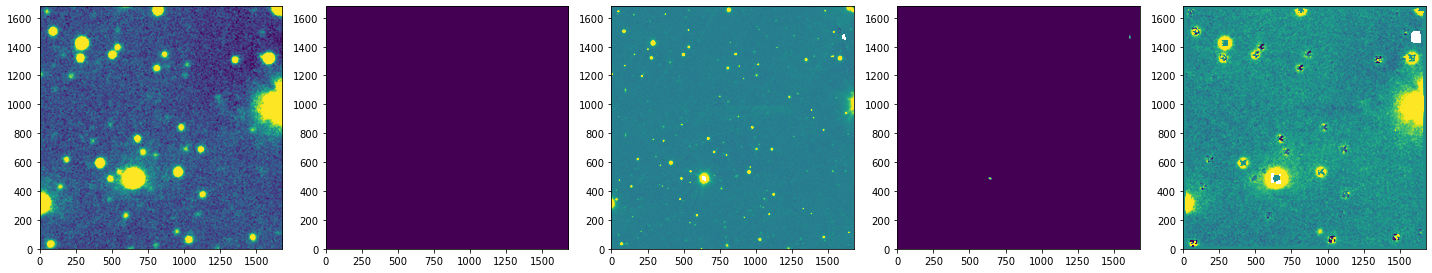

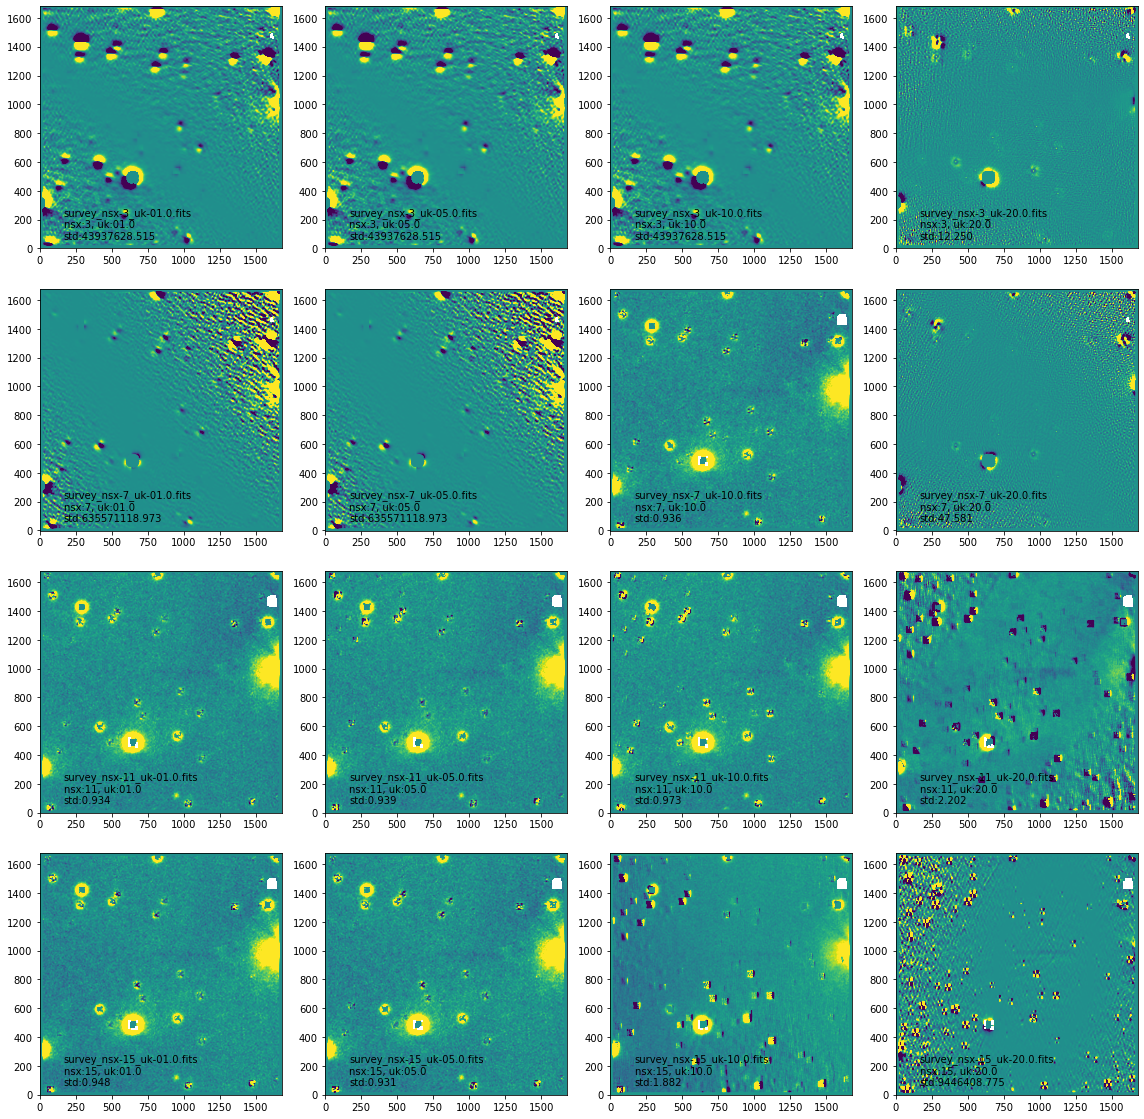

In [13]:
EXACT = True
NAME = "solve.fits"
HDU1 = pf.open(NAME)[0]
w = WCS(HDU1.header)

filters = "r"
SIZE = 7.0
fps1 = get_ps1(w,SIZE,filters)
hdu1 = pf.open(NAME)[0]
hdu2 = pf.open(fps1)[0]
w = WCS(hdu2.header)
if "GAIN"    in hdu1.header.keys():gain = hdu1.header['GAIN']
else:                       gain = 1.0
gain = 1.0
if 'RONOISE' in hdu1.header.keys():rnoi = hdu1.header['RONOISE']
else:                       rnoi = 1.0
im_in, im_out, params = est_good_sub(NAME, fps1, gain, rnoi)
plot_best(im_in=im_in, im_ref=fps1, im_out=im_out)
plot_surv(input_image=NAME, params=params)
write_tab(input_image=NAME, params=params)


In [14]:
ascii.read("solve_s.csv")

<Table length=16>
           File             nsx     uk          nstd            std     
          str26            int64 float64      float64         float64   
-------------------------- ----- ------- ------------------ ------------
 survey_nsx-3_uk-01.0.fits     3     1.0  43937628.51514691   75443760.0
 survey_nsx-3_uk-05.0.fits     3     5.0  43937628.51514691   75443760.0
 survey_nsx-3_uk-10.0.fits     3    10.0  43937628.51514691   75443760.0
 survey_nsx-3_uk-20.0.fits     3    20.0  12.25003283572851    21.034101
 survey_nsx-7_uk-01.0.fits     7     1.0  635571118.9732206 1091316900.0
 survey_nsx-7_uk-05.0.fits     7     5.0  635571118.9732206 1091316900.0
 survey_nsx-7_uk-10.0.fits     7    10.0 0.9364297336471332    1.6079106
 survey_nsx-7_uk-20.0.fits     7    20.0  47.58128644659357     81.70016
survey_nsx-11_uk-01.0.fits    11     1.0 0.9335990192435379    1.6030501
survey_nsx-11_uk-05.0.fits    11     5.0 0.9390889653396971    1.6124767
survey_nsx-11_uk-10.0.fits    11    10.0 0.9730291428675322    1.6707542
survey_nsx-11_uk-20.0.fits    11    20.0  2.201504763888031    3.7801266
survey_nsx-15_uk-01.0.fits    15     1.0 0.9478268772942283    1.6274803
survey_nsx-15_uk-05.0.fits    15     5.0  0.931488254521479    1.5994258
survey_nsx-15_uk-10.0.fits    15    10.0 1.8820774614134865    3.2316492
survey_nsx-15_uk-20.0.fits    15    20.0  9446408.774770092   16220097.0